In [65]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

sns.set_context('notebook')
%matplotlib inline
sns.set_style("darkgrid")

# Task A

In [66]:
house_train = pd.read_csv('train.csv')
house_test = pd.read_csv('test.csv')

In [67]:
house_train.describe().round(4)

,Train_ID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,1570.0000,1570.0000,1306.0000,1570.0000,1570.0000,1570.0000,1570.0000,1570.0000,1555.0000,1569.0000,...,1570.0000,1570.0000,1570.0000,1570.0000,1570.0000,1570.0000,1570.000,1570.0000,1570.0000,1570.0000
mean,785.5000,56.8439,69.9158,10359.4854,6.0866,5.5599,1971.8720,1984.6885,104.5994,446.5430,...,92.7936,48.9567,23.5752,2.6860,16.1605,2.4611,56.186,6.1955,2007.7809,183176.0522
std,453.3643,41.5175,22.3673,9154.4136,1.4079,1.0960,30.0443,20.5534,177.7614,450.4333,...,128.9138,67.6715,63.2842,25.9145,56.4710,37.6391,697.558,2.7728,1.3269,81524.9317
min,1.0000,20.0000,21.0000,1470.0000,1.0000,1.0000,1875.0000,1950.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,1.0000,2006.0000,13100.0000
25%,393.2500,20.0000,59.0000,7500.0000,5.0000,5.0000,1954.0000,1967.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,4.0000,2007.0000,131000.0000
50%,785.5000,50.0000,70.0000,9463.0000,6.0000,5.0000,1974.0000,1993.0000,0.0000,376.0000,...,0.0000,28.0000,0.0000,0.0000,0.0000,0.0000,0.000,6.0000,2008.0000,162500.0000
75%,1177.7500,70.0000,80.0000,11643.0000,7.0000,6.0000,2000.0000,2003.0000,174.0000,733.0000,...,167.7500,74.0000,0.0000,0.0000,0.0000,0.0000,0.000,8.0000,2009.0000,215000.0000
max,1570.0000,190.0000,195.0000,215245.0000,10.0000,9.0000,2010.0000,2010.0000,1290.0000,4010.0000,...,1424.0000,742.0000,584.0000,407.0000,490.0000,800.0000,17000.000,12.0000,2010.0000,755000.0000


In [68]:
len(house_train.dtypes)

81

In [69]:
corr = pd.DataFrame(house_train.drop('Train_ID',1).corr().round(3).sort_values('SalePrice')['SalePrice'])
high_corr = corr[abs(corr['SalePrice'])>=0.5]

In [70]:
var = list(high_corr.index.values)

In [71]:
var

['TotRms AbvGrd',
 'Year Remod/Add',
 'Garage Yr Blt',
 'Year Built',
 'Full Bath',
 'Garage Area',
 '1st Flr SF',
 'Garage Cars',
 'Total Bsmt SF',
 'Gr Liv Area',
 'Overall Qual',
 'SalePrice']

KeyboardInterrupt: 

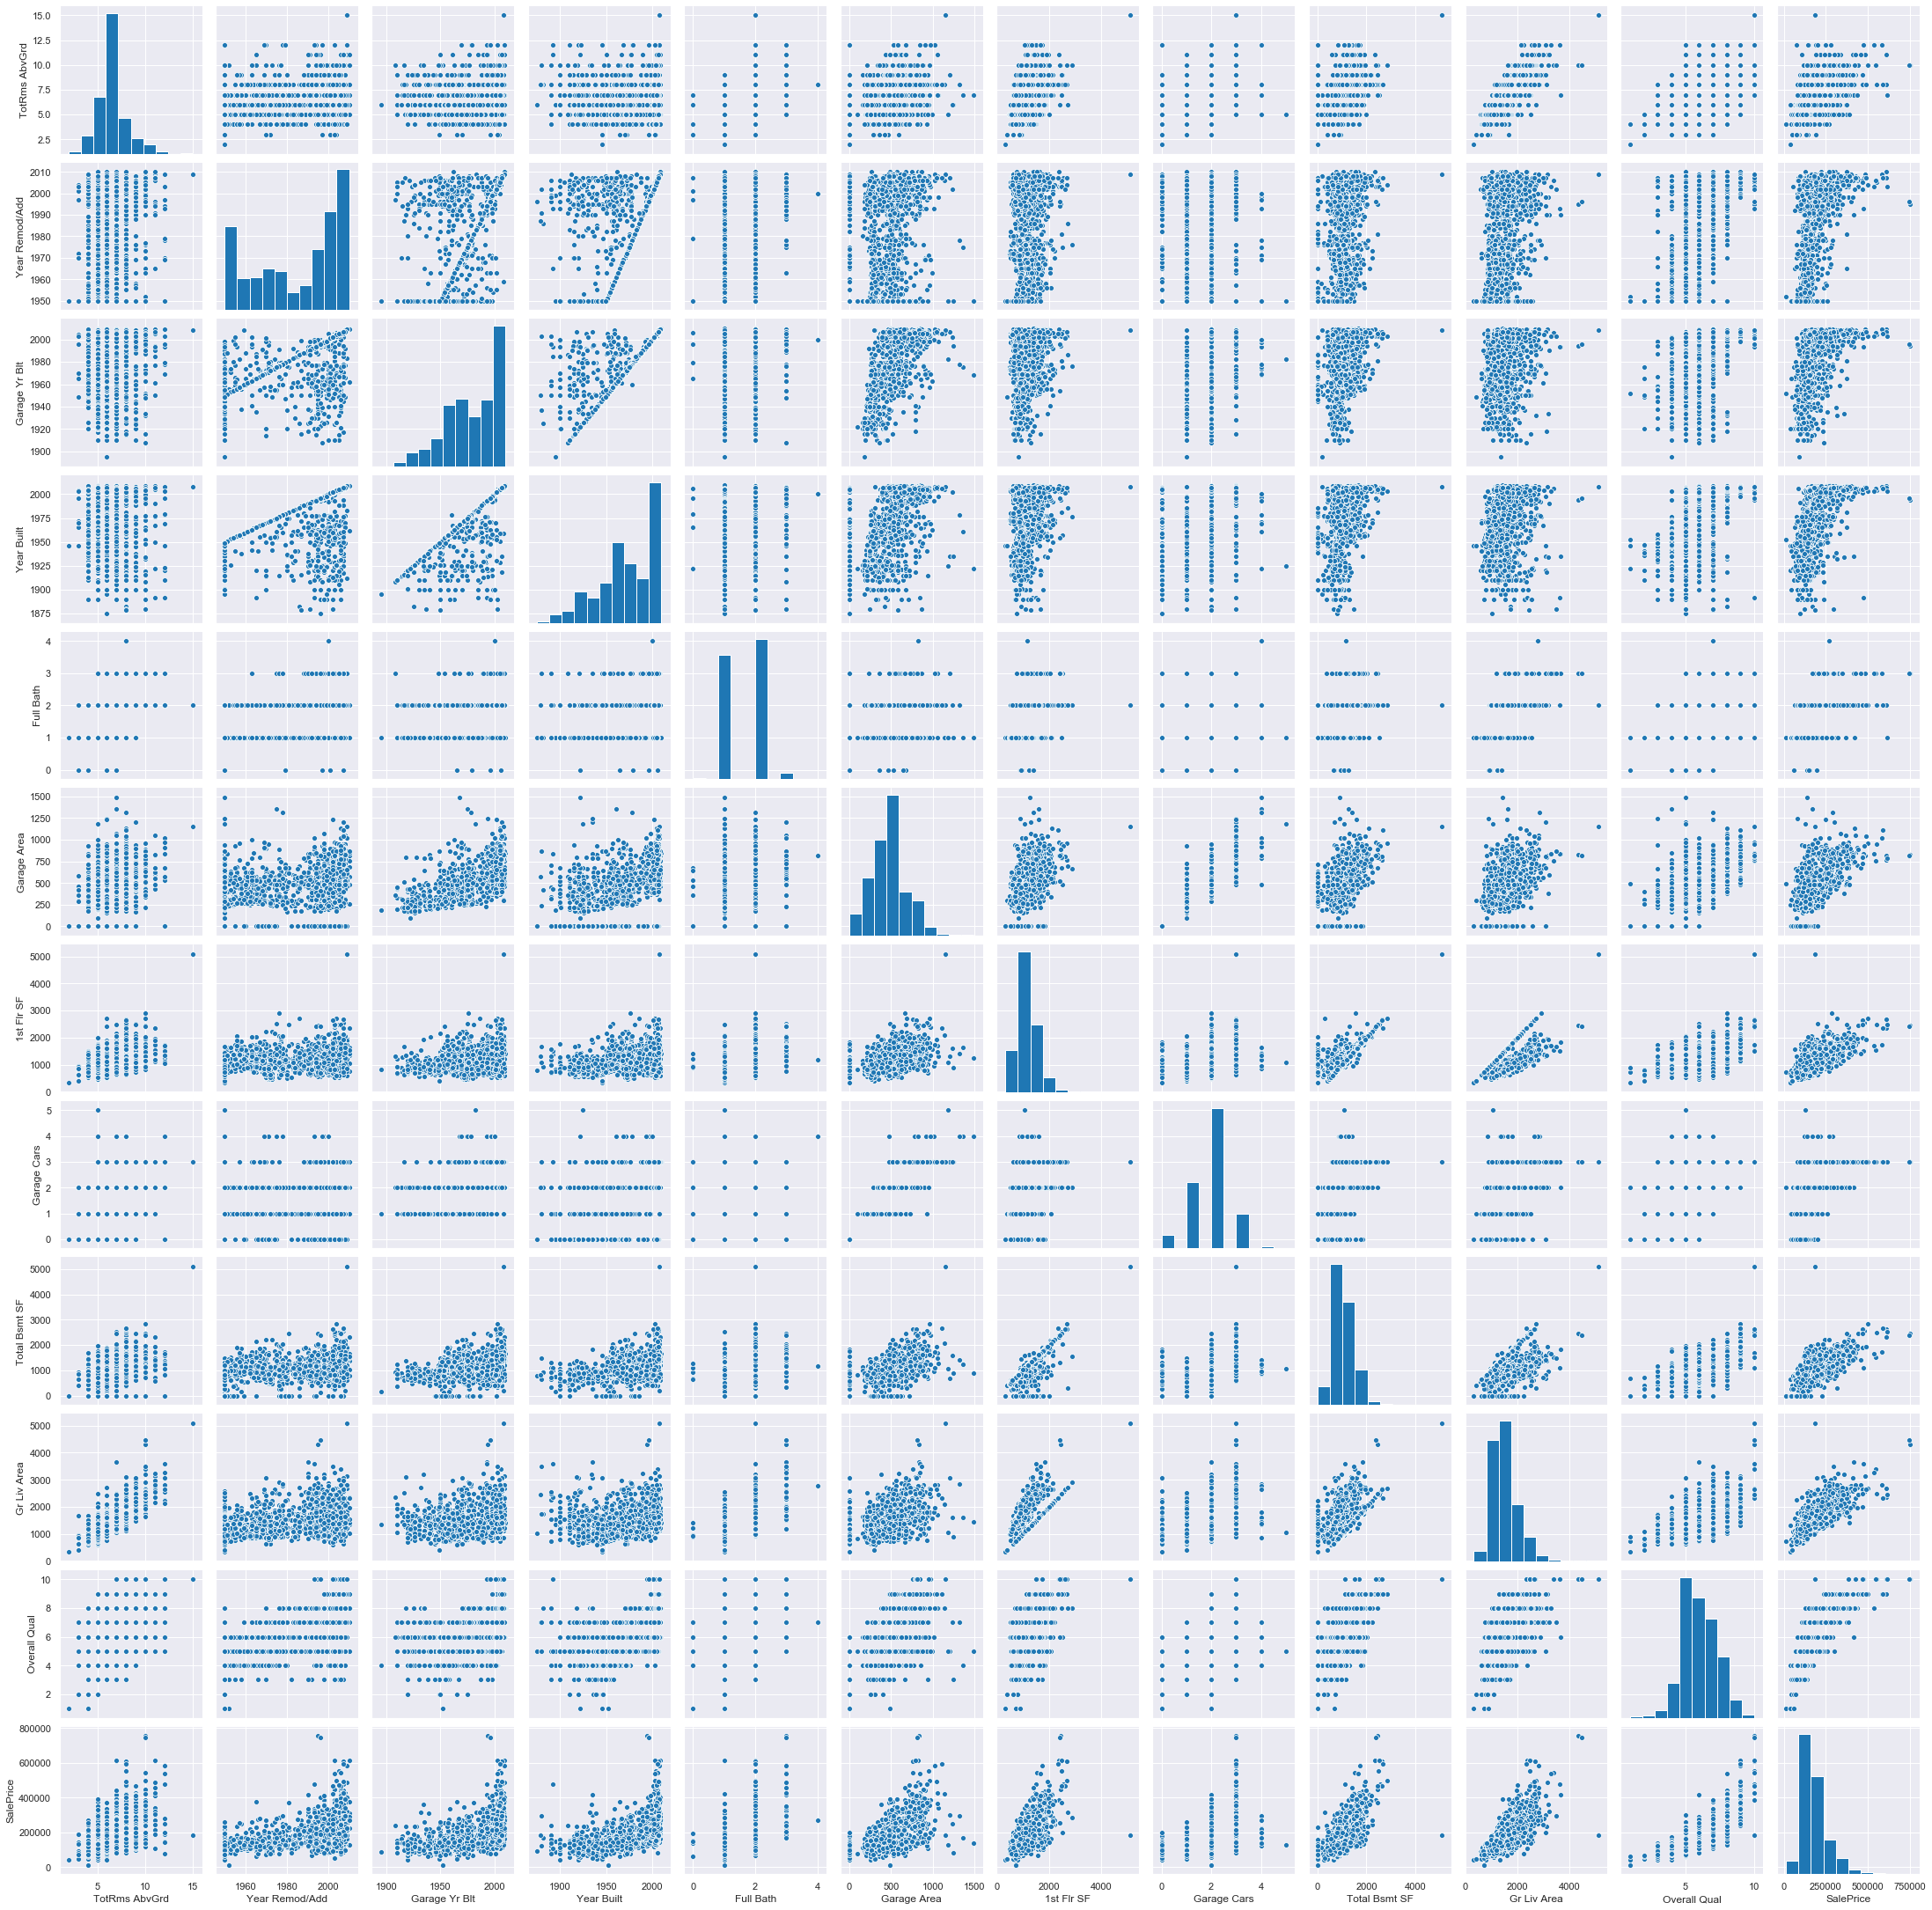

In [72]:
features = house_train[var]
plt1=sns.pairplot(features)
plt1.savefig("scatter.png")

In [ ]:
cat = house_train.loc[:, house_train.dtypes=='object']
cat = cat.drop('Pool QC',axis=1)
cat['Sale price']=house_train['SalePrice']

fig, axes = plt.subplots(7,6, figsize = (18,14),sharey='row')
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(1,43):
    plt.subplot(7,6,i)
    var = list(cat.columns.values)[i-1]
    sub = sns.boxplot(x=cat.iloc[:,i-1],y=cat['Sale price'])
    sub.set(xlabel=var, ylabel="Sale price")
    plt.setp(sub,xticks=[],yticks=[]) 

# plt.savefig("boxplot.png")

# Feature Engineering

In [ ]:
import missingno as msno
msno.bar(house_train.iloc[:,1:41])

In [ ]:
msno.bar(house_train.iloc[:,41:82])

In [ ]:
missing_count = pd.DataFrame(house_train.isna().sum())
missing = missing_count[missing_count[0]!=0]
missing['percentage']=missing[0]/len(house_train)*100
missing.sort_values('percentage')
remove = list(missing[missing['percentage']>=40].index.values)
train = house_train.drop(remove,axis=1)
test = house_test.drop(remove,axis=1)

In [ ]:
missing.sort_values('percentage')

In [ ]:
remove

In [ ]:
from sklearn.impute import SimpleImputer
train = train.drop(['Train_ID','SalePrice'],axis=1)
imp = SimpleImputer(strategy="most_frequent")
imp.fit(train)
trainHouse = pd.DataFrame(imp.transform(train))
trainHouse.columns = list(train.columns.values)

for i in train:
    trainHouse[i] = trainHouse[i].astype(train[i].dtype)
    
numeric = trainHouse.loc[:, trainHouse.dtypes!='object']

In [ ]:
len(numeric.columns)

In [ ]:
predictors = numeric.columns.values
X=pd.DataFrame()
mu=numeric[predictors].mean() # mean for each feature
sigma=numeric[predictors].std() # std for each feature
X[predictors]=(numeric[predictors]-mu)/sigma

Y = house_train['SalePrice']

In [ ]:
allVar = pd.get_dummies(trainHouse)
predictors1 = allVar.columns.values

X1=allVar
mu1=allVar[predictors].mean() # mean for each feature
sigma1=allVar[predictors].std() # std for each feature
X1[predictors]=(allVar[predictors]-mu1)/sigma1

In [ ]:
test_drop = test.drop('Test_ID',axis=1)
testHouse = pd.DataFrame(imp.transform(test_drop))
testHouse.columns = list(test_drop.columns.values)

# testHouse
for i in testHouse:
    testHouse[i] = testHouse[i].astype(test_drop[i].dtype)

test = testHouse.loc[:, testHouse.dtypes!='object']
predictors_test = test.columns.values
mu_test = mu[predictors_test]
test[predictors_test]=(testHouse[predictors_test]-mu_test)/sigma

In [ ]:
testHouse1 = pd.DataFrame(imp.transform(test_drop))
testHouse1.columns = list(test_drop.columns.values)

for i in testHouse1:
    testHouse1[i] = testHouse1[i].astype(test_drop[i].dtype)

all_test = pd.get_dummies(testHouse1)
test1 = all_test
test1[predictors]=(all_test[predictors]-mu1)/sigma1

In [ ]:
features = list(test1.columns.values)
var = list(X1.columns.values)
for i in range(len(var)):
    if var[i] not in features:
        test1[var[i]]=[0] * len(test1)

for i in range(len(features)):
    if features[i] not in var:
        X1[features[i]] = [0] *len(X1)


As shown in the missing plot, there are huge amounts of missing values in several columns: 'Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature'. By calculating the number of null values, these 5 columns are found to have more than 40% missing values within each column. With this issue, such variables are uninformative to ba a feature of predictive models as too few observations are provided. Removing all rows with missing values can lead to significant loss of data while imputation is not appropriate for such largely incomplete columns. Therefore, 'Alley', 'Pool QC', 'Fence', 'Misc Feature' are abandoned.

Besides, there are 19 columns containing missing value but the percentages of missing values are less than 20%. This can be dealed with by imputation. The missing values are imputed by using the most frequent value of each columns.

To deal with outliers of numeric features, standardisation is performed by subtracting the mean, followed by dividing the standard deviation of the corresponding columns. 

After feature engineering, there are 74 informative features, with 36 features being numerical and 38 features being categorical. There are 1570 in the training set while 1210 observations remain  in the testing set. In order to involve categorical features in regression models, dummy variables are created for each categorical feature.

# Multiple Linear Regression with forward selection

- forward selection

In [ ]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

def rmse_jack(response, predicted):
    
    y = np.array((np.ravel(response)-np.ravel(predicted))**2)
    y_sum = np.sum(y)
    n = len(y)

    resample = np.sqrt((y_sum-y)/(n-1))

    rmse = np.sqrt(y_sum/n)
    se = np.sqrt((n-1)*np.var(resample))

    return rmse, se


def r2_jack(response, predicted):


    e2 = np.array((np.ravel(response)-np.ravel(predicted))**2)
    y2 = np.array((np.ravel(response)-np.mean(np.ravel(response)))**2)

    rss = np.sum(e2)
    tss = np.sum(y2)
    n = len(e2)

    resample = 1-(rss-e2)/(tss-y2)

    r2 = 1-rss/tss
    se = np.sqrt((n-1)*np.var(resample))

    return r2, se


def forwardselection(X, y):
    """Forward variable selection based on the Scikit learn API
    
    
    Output:
    ----------------------------------------------------------------------------------
    Scikit learn OLS regression object for the best model
    """

    # Functions
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score

    # Initialisation
    base = []
    p = X.shape[1]
    candidates = list(np.arange(p))

    # Forward recursion
    i=1
    bestcvscore=-np.inf    
    while i<=p:
        bestscore = 0
        for variable in candidates:
            ols = LinearRegression()
            ols.fit(X.iloc[:, base + [variable]], y)
            score = ols.score(X.iloc[:, base + [variable]], y)
            if score > bestscore:
                bestscore = score 
                best = ols
                newvariable=variable
        base.append(newvariable)
        candidates.remove(newvariable)
        
        cvscore = cross_val_score(best, X.iloc[:, base], y, scoring='neg_mean_squared_error').mean() 
        
        if cvscore > bestcvscore:
            bestcvscore=cvscore
            bestcv = best
            subset = base[:]
        i+=1
    
    #Finalise
    return bestcv, subset


class forward:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.ols, self.subset = forwardselection(X, y)

    def predict(self, X):
        return self.ols.predict(X.iloc[:, self.subset])

    def cv_score(self, X, y, cv=10):
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(self.ols, X.iloc[:, self.subset], np.ravel(y), cv=cv, scoring='neg_mean_squared_error')
        return np.sqrt(-1*np.mean(scores))
        

class PCR:
    def __init__(self, M=1):
        self.M=M

    def fit(self, X, y):
        from sklearn.decomposition import PCA
        from sklearn.linear_model import LinearRegression
        
        self.pca=PCA(n_components=self.M)
        Z= self.pca.fit_transform(X)
        self.pcr = LinearRegression().fit(Z, y)

    def predict(self, X):
        return self.pcr.predict(self.pca.transform(X))

    def cv_score(self, X, y, cv=10):
        from sklearn.model_selection import cross_val_score
        Z=self.pca.transform(X)
        scores = cross_val_score(self.pcr, Z, np.ravel(y), cv=cv, scoring='neg_mean_squared_error').mean() 
        return np.sqrt(-1*np.mean(scores))


def pcrCV(X, y):
    # Approximate cross-validation
    from sklearn.model_selection import cross_val_score
    
    p=X.shape[1]
    bestscore= -np.inf
    cv_scores = []
    for m in range(1,p+1):
        model = PCR(M=m)
        model.fit(X, y)
        Z=model.pca.transform(X)
        score = cross_val_score(model.pcr, Z, y, cv=10, scoring='neg_mean_squared_error').mean() 
        cv_scores.append(score)
        if score > bestscore:
            bestscore=score
            best=model

    best.cv_scores = pd.Series(cv_scores, index = np.arange(1,p+1))
    return best


def plsCV(X, y):

    from sklearn.cross_decomposition import PLSRegression
    from sklearn.model_selection import cross_val_score
    
    p=X.shape[1]
    bestscore=-np.inf
    for m in range(1,p): # not fitting with M=p avoids occasional problems
        pls = PLSRegression(n_components=m).fit(X, y)
        score = cross_val_score(pls, X, y, cv, scoring='neg_mean_squared_error').mean() 
        if score > bestscore:
            bestscore=score
            best=pls
    return best

In [ ]:
fwd = forward()
fwd.fit(X,Y)

fwd1 = forward()
fwd1.fit(X1,Y)

In [ ]:
cv, subset = forwardselection(X, Y)
select = X.iloc[:,subset]
select

In [ ]:
cv1, subset1 = forwardselection(X1, Y)
select1 = X1.iloc[:,subset1]
select1

# KNN Regression

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
neighbours=np.arange(1, 101)

cv_rmse = []
for k in neighbours: 
    knn = KNeighborsRegressor(n_neighbors= k) 
    scores = cross_val_score(knn, X, Y, cv=5, scoring = 'neg_mean_squared_error')
    # taking the average MSE across folds, then taking the square root to generate RMSE
    rmse = np.sqrt(-1*np.mean(scores)) 
    cv_rmse.append(rmse)
    knn.fit(X,Y)

optimal_k = 1 + np.argmin(cv_rmse)

print('Lowest CV error: K = {}'.format(optimal_k)) 
knn = KNeighborsRegressor(n_neighbors= optimal_k) 
knn.fit(X,Y)

In [ ]:
cv_rmse = []
for k in neighbours: 
    knn1 = KNeighborsRegressor(n_neighbors= k) 
    scores = cross_val_score(knn1, X1, Y, cv=5, scoring = 'neg_mean_squared_error')
    # taking the average MSE across folds, then taking the square root to generate RMSE
    rmse = np.sqrt(-1*np.mean(scores)) 
    cv_rmse.append(rmse)
    knn1.fit(X1,Y)

optimal_k = 1 + np.argmin(cv_rmse)

print('Lowest CV error: K = {}'.format(optimal_k)) 
knn1 = KNeighborsRegressor(n_neighbors= optimal_k) 
knn1.fit(X1,Y)

# LASSO Regression

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression

lasso = LassoCV(cv=5,random_state=1)# scoring: -ve MSE
lasso.fit(X, Y)# the np.ravel is a necessary detail for compatibility
print("LASSO Lambda: {0}".format(lasso.alpha_))

# shrinkage factor:

ols = LinearRegression()
ols.fit(X, Y)
np.linalg.norm(lasso.coef_, ord=1)/np.linalg.norm(np.ravel(ols.coef_), ord=1)

coef = pd.DataFrame(lasso.coef_.round(3), index = predictors)
select = coef[coef[0]!=0]

In [ ]:
lasso1 = LassoCV(cv=5,random_state=1)# scoring: -ve MSE
lasso1.fit(X1, Y)# the np.ravel is a necessary detail for compatibility

ols1 = LinearRegression()
ols1.fit(X1, Y)


In [ ]:
print("LASSO Lambda: {0}".format(lasso1.alpha_))

# Ridge Regression

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

alphas = np.exp(np.linspace(-10,20,500)) 
ridge_cv = RidgeCV(alphas=alphas, cv=5) 
ridge_cv.fit(X, Y)

ridge = Ridge(alpha=ridge_cv.alpha_)
ridge.fit(X, np.ravel(Y))

print("Ridge Lambda: {0}".format(ridge_cv.alpha_))

In [ ]:
ridge_cv1 = RidgeCV(alphas=alphas, cv=5) 
ridge_cv1.fit(X1, Y)

ridge1 = Ridge(alpha=ridge_cv1.alpha_)
ridge1.fit(X1, np.ravel(Y))

print("Ridge Lambda: {0}".format(ridge_cv1.alpha_))

# ElasticNetCV

can do certain level of feature selection

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
enet_cv = ElasticNetCV(l1_ratio=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99], cv=5)
enet_cv.fit(X,Y)

enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)
enet.fit(X,np.ravel(Y))
print("Elastic Net Lambda: {0}".format(enet_cv.alpha_))

In [ ]:
enet_cv1 = ElasticNetCV(l1_ratio=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99], cv=5)
enet_cv1.fit(X1,Y)

enet1 = ElasticNet(alpha=enet_cv1.alpha_, l1_ratio=enet_cv1.l1_ratio_)
enet1.fit(X1,np.ravel(Y))

In [ ]:
print("Elastic Net Lambda: {0}".format(enet_cv1.alpha_))

# Random Forest Regression

This tells us the most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
print(n_estimators)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features
               }

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')
grid_search.fit(X,Y)

In [ ]:
grid_best = grid_search.best_params_
rf_rmse = np.sqrt(-grid_search.best_score_).round(4)

print("For random forest model with numeric features:")
print("Optimal random forest model: ",grid_best)
print("Validation RMSE: ",rf_rmse)

In [ ]:
rf_pred = pd.DataFrame(grid_search.predict(test))
rf_pred['Test_ID'] = house_test['Test_ID']
rf_pred = rf_pred.rename(columns={0:'SalePrice'})
rf_pred= rf_pred[['Test_ID','SalePrice']]
rf_pred.to_csv("predictions/rf_pred.csv")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf1 = RandomForestRegressor()

grid_search1 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')
grid_search1.fit(X1,Y)

grid_best1 = grid_search1.best_params_
rf_rmse1 = np.sqrt(-grid_search1.best_score_).round(4)

rf_pred1 = pd.DataFrame(grid_search1.predict(test1))
rf_pred1['Test_ID'] = house_test['Test_ID']
rf_pred1 = rf_pred1.rename(columns={0:'SalePrice'})
rf_pred1= rf_pred1[['Test_ID','SalePrice']]
rf_pred1.to_csv("predictions/rf_pred1.csv")

In [ ]:
print("For random forest model with both categorical numeric features:")
print("Optimal random forest model: ",grid_best1)
print("Validation RMSE: ",rf_rmse1)

# Cross validation results

Which methods does cross validation suggest may perform best for the test data? 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Cross validator
kf=KFold(10, shuffle=True, random_state=1) 

# Methods
columns = ['Numeric variables',"Numeric and categorical variables"]
rows = ['Forward','KNN','Lasso', 'Ridge','Elastic Net','Random forest']

regressions = [fwd, knn, lasso, ridge, enet]
results = pd.DataFrame(0.0, columns=columns, index=rows) # initialising a dataframe to hold the results

methods = {k: v for k, v in zip(rows, regressions)}

# Computing the results (Scikit Learn objects)
keys = ['KNN','Lasso', 'Ridge','Elastic Net']
for key in keys:
    scores = cross_val_score(methods[key], X, np.ravel(Y), cv=kf, scoring = 'neg_mean_squared_error')
    results.loc[key][0] = np.sqrt(-1*np.mean(scores))

results.loc['Forward'][0] = fwd.cv_score(X, np.ravel(Y), cv=kf)
results.loc['Random forest'][0] = rf_rmse
# results = results.round(3).sort_values('CV RMSE')

In [ ]:
regressions = [fwd1, knn1, lasso1, ridge1, enet1]
for key in keys:
    scores = cross_val_score(methods[key], X1, np.ravel(Y), cv=kf, scoring = 'neg_mean_squared_error')
    results.loc[key][1] = np.sqrt(-1*np.mean(scores))
results.loc['Forward'][1] = fwd1.cv_score(X1, np.ravel(Y), cv=kf)
results.loc['Random forest'][1] = rf_rmse1

In [ ]:
results

In [ ]:
fwd_pred = pd.DataFrame(fwd.predict(test))
fwd_pred['Test_ID'] = house_test['Test_ID']
fwd_pred = fwd_pred.rename(columns={0:'SalePrice'})
fwd_pred = fwd_pred[['Test_ID','SalePrice']]
fwd_pred.to_csv("predictions/fwd_pred.csv")

In [ ]:
# ridge_pred = pd.DataFrame(ridge1.predict(test1))
fwd_pred1 = pd.DataFrame(fwd1.predict(test1))
fwd_pred1['Test_ID'] = house_test['Test_ID']
fwd_pred1 = fwd_pred1.rename(columns={0:'SalePrice'})
fwd_pred1 = fwd_pred1[['Test_ID','SalePrice']]
fwd_pred1.to_csv("predictions/fwd_pred1.csv")

In [ ]:
ridge_pred = pd.DataFrame(ridge.predict(test))
ridge_pred['Test_ID'] = house_test['Test_ID']
ridge_pred = ridge_pred.rename(columns={0:'SalePrice'})
ridge_pred = ridge_pred[['Test_ID','SalePrice']]
ridge_pred.to_csv("predictions/ridge_pred.csv")

ridge_pred1 = pd.DataFrame(ridge1.predict(test1))
ridge_pred1['Test_ID'] = house_test['Test_ID']
ridge_pred1 = ridge_pred1.rename(columns={0:'SalePrice'})
ridge_pred1 = ridge_pred1[['Test_ID','SalePrice']]
ridge_pred1.to_csv("predictions/ridge_pred1.csv")

In [ ]:
lasso_pred = pd.DataFrame(lasso.predict(test))
lasso_pred['Test_ID'] = house_test['Test_ID']
lasso_pred = lasso_pred.rename(columns={0:'SalePrice'})
lasso_pred = lasso_pred[['Test_ID','SalePrice']]
lasso_pred.to_csv("predictions/lasso_pred.csv")

lasso_pred1 = pd.DataFrame(lasso1.predict(test1))
lasso_pred1['Test_ID'] = house_test['Test_ID']
lasso_pred1 = lasso_pred1.rename(columns={0:'SalePrice'})
lasso_pred1 = lasso_pred1[['Test_ID','SalePrice']]
lasso_pred1.to_csv("predictions/lasso_pred1.csv")

In [ ]:
enet_pred = pd.DataFrame(enet.predict(test))
enet_pred['Test_ID'] = house_test['Test_ID']
enet_pred = enet_pred.rename(columns={0:'SalePrice'})
enet_pred = enet_pred[['Test_ID','SalePrice']]
enet_pred.to_csv("predictions/enet_pred.csv")

enet_pred1 = pd.DataFrame(enet1.predict(test1))
enet_pred1['Test_ID'] = house_test['Test_ID']
enet_pred1 = enet_pred1.rename(columns={0:'SalePrice'})
enet_pred1 = enet_pred1[['Test_ID','SalePrice']]
enet_pred1.to_csv("predictions/enet_pred1.csv")

# citation

- Little, Roderick JA, and Donald B. Rubin. “Statistical analysis with missing data.” (2002).
- https://scikit-learn.org/stable/modules/impute.html
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- Hintze, J.L., 1992. Chapter 335: Ridge Regression. In Number cruncher statistical system: statistical software. Kaysville, UT: Jerry L. Hintze. 
- Chakon, O. (2017). Practical Machine Learning: Ridge Regression Vs Lasso. Coding Startups: Coders With Entrepreneurial Mindset. Published August 3rd, 2017.
- Allison, P. (2012, September 10). When Can You Safely Ignore Multicollinearity? Statistical Horizons.
- Cross Validated. (2015, November 28). What is elastic net regularization, and how does it solve the drawbacks of Ridge (L2) and Lasso (L1)? Retrieved from https://stats.stackexchange.com/questions/184029/what-is-elastic-net-regularization-and-how-doesitsolve-the-drawbacks-of-ridge/184031#184031
- https://medium.com/@raj5287/effects-of-multi-collinearity-in-logistic-regression-svm-rf-af6766d91f1b#:~:text=Random%20Forest%20uses%20bootstrap%20sampling,different%20set%20of%20data%20points.


# Task B

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
import datetime
visitor = pd.read_csv('visitors.csv', index_col='Date', parse_dates=True)

visitor.index  = pd.to_datetime(visitor.index, format='%b-%y').to_period()

In [4]:
y = visitor['Number of Visitors']

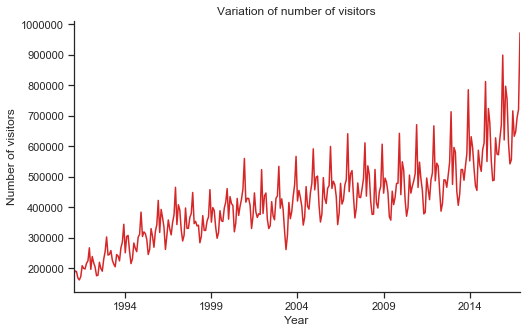

In [40]:
fig, ax= plt.subplots(figsize=(8,5))
figure = y.plot(color=red)
ax.set_xlabel('Year')
ax.set_ylabel('Number of visitors')
ax.set_title('Variation of number of visitors')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()

The time series plot of number of visitors shows a upward trend from 1991 to 2016, with a seasonal pattern as symtematic changes occur in short periods which are fixed. Furthermore, the variation of number of visitors within the fixed period becomes greater as time moves. As such, a multiplicative forecasting model may be more suitable for this data compared to an additive model.

In [6]:
y.describe().round(2)

count       312.00
mean     419407.37
std      132443.06
min      161400.00
25%      332625.00
50%      412950.00
75%      488775.00
max      971800.00
Name: Number of Visitors, dtype: float64

In [76]:
y_test = y['2010-01':]
y_train = y[:'2010-01']

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm


@jit
def exponentialsmoothing(y, alpha):
    n=len(y)
    l=np.zeros(n)
    l[0]=y[0]
    for i in range(1,n):
        l[i]=alpha*y[i-1]+(1-alpha)*(l[i-1])
    return l

class ses:
    def __init__(self, y):
        assert type(y)==pd.core.series.Series, 'Input must be a pandas series'
        self.time=y.index
        self.y=y.values
        self.n=len(self.y)
    
    def smooth(self):
        return exponentialsmoothing(self.y, self.alpha)

    def mse(self, alpha):
        x=exponentialsmoothing(self.y, alpha)
        return np.mean(np.power(self.y-x,2))

    def loss(self, alpha):
        return (1/2)*np.log(self.mse(alpha))

    def fit(self, start=0.1):
        result=minimize(self.loss, start, bounds=((0,1),), tol=1e-6, method='L-BFGS-B')   
        self.alpha=float(result.x)       
        self.sigma2=self.mse(self.alpha)
        self.se=np.sqrt(np.diag((1/self.n)*result.hess_inv.todense()))
        self.fitted=self.smooth()
        self.resid=self.y-self.fitted

    def forecast(self, h):
        return np.repeat(self.smooth()[-1], h)

    def intervalforecast(self, h, level=.95):
        fitted=self.smooth()
        sigma2=self.sigma2
        forecast=np.repeat(fitted[-1], h)
        crit=stats.norm.ppf(1-(1-level)/2)
        ci=np.zeros((h,2))
        lvar=0
        for i in range(h):
            lvar+=(self.alpha**2)*(sigma2)
            var=lvar+sigma2
            ci[i,0], ci[i,1]= forecast[i]-crit*np.sqrt(var), forecast[i]+crit*np.sqrt(var)
        return ci

    def summary(self):
        N=self.n
        mse=self.sigma2
        loglik=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse)
        aic=-2*loglik+2*3
        bic=-2*loglik+np.log(N)*3
        print(' Simple exponential smoothing\n')
        print(' Smoothing parameter:')
        print(' alpha  {0:.3f} ({1:.3f}) \n'.format(self.alpha, self.se[0]))
        print(' In-sample fit:')
        print(' MSE               {0:.3f}'.format(mse))
        if loglik>0:
            print(' Log-likelihood    {0:.3f}'.format(loglik))
        else: 
            print(' Log-likelihood   {0:.3f}'.format(loglik))
        print(' AIC               {0:.3f}'.format(aic))
        print(' BIC               {0:.3f}'.format(bic))
        self.aic=aic
        self.bic=bic


@jit
def holtsmooth(y, alpha, beta, phi):
    n=len(y)
    l=np.zeros(n)
    b=np.zeros(n)
    l[0]=y[0]
    b[0]=0
    for i in range(1,n):
        l[i]=alpha*y[i-1]+(1-alpha)*(l[i-1]+phi*b[i-1])
        b[i]=beta*(l[i]-l[i-1])+(1-beta)*(phi*b[i-1])
    return l, b

class holt:
    def __init__(self, y, damped=False):
        assert type(y)==pd.core.series.Series, 'Input must be a pandas series'
        self.time=y.index
        self.y=y.values
        self.n=len(self.y)
        self.damped=damped
    
    def smooth(self):
        if self.damped:
            l, b =holtsmooth(self.y, self.alpha, self.beta, self.phi)
        else:
            l, b =holtsmooth(self.y, self.alpha, self.beta, 1.0)
        return l+b

    def mse(self, theta):
        if self.damped:
            l, b =holtsmooth(self.y, theta[0], theta[1], theta[2])
        else:
            l, b= holtsmooth(self.y, theta[0], theta[1], 1.0)
        return np.mean(np.power(self.y-l-b,2))

    def loss(self, theta):
        mse=self.mse(theta)
        return (1/2)*np.log(mse)

    def fit(self, start=np.array([0.3,0.05])):
        if self.damped==False:
            result=minimize(self.loss, start,  bounds=((0,1),(0,1)), tol=1e-6, method='L-BFGS-B') 
        else:
            if len(start)==2:
                start=np.array([0.1,0.1, 0.98])
            result=minimize(self.loss, start,  bounds=((0,1),(0,1), (0,1)), tol=1e-6, method='L-BFGS-B')   
            self.phi=float(result.x[2])
        self.alpha=float(result.x[0])
        self.beta=float(result.x[1])
        self.params=result.x
        self.sigma2=self.mse(self.params)
        self.se=np.sqrt(np.diag((1/self.n)*result.hess_inv.todense()))
        self.fitted=self.smooth()
        self.resid=self.y-self.fitted
         
    def forecast(self, h):
        if self.damped:
            l, b= holtsmooth(self.y, self.alpha, self.beta, self.phi)
            prediction=np.zeros(h)
            yhat=l[-1]
            for i in range(h):
                yhat+=np.power(self.phi, i+1)*b[-1]
                prediction[i]=yhat
            return prediction
        else:
            l, b= holtsmooth(self.y, self.alpha, self.beta, 1.0)
            return l[-1]+(1+np.arange(h))*b[-1]

    def forecastvariance(self, h):
        sigma2=self.sigma2
        result=np.zeros(h)
        var=sigma2
        aux=1
        for i in range(h):
            result[i]=var
            if self.damped:
                aux+=(self.phi**(1+i))*(self.beta)
            else: 
                aux+=self.beta
            var+=np.power(self.alpha*aux,2)*sigma2
        return result
        
    def intervalforecast(self, h, level=.95):
        sigma2=self.sigma2
        crit=stats.norm.ppf(1-(1-level)/2)
        forecast=np.reshape(self.forecast(h), (h,1))
        var=np.reshape(self.forecastvariance(h), (h,1))
        return np.hstack((forecast-crit*np.sqrt(var), forecast+crit*np.sqrt(var)))

    def summary(self):
        N=self.n
        mse=self.sigma2
        loglik=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse)
        if self.damped:
            aic=-2*loglik+2*4
            bic=-2*loglik+np.log(N)*4
        else:
            aic=-2*loglik+2*3
            bic=-2*loglik+np.log(N)*3
        if self.damped:
            print(' Holt exponential smoothing (damped trend)\n')
        else: 
            print(' Holt (trend corrected) exponential smoothing\n')
        print(' Smoothing parameters: ')
        print(' alpha (level) {0:.3f} ({1:.3f})'.format(self.alpha, self.se[0]))
        print(' beta (trend)  {0:.3f} ({1:.3f})'.format(self.beta, self.se[1]))
        if self.damped:
            print(' phi (damping) {0:.3f} ({1:.3f})'.format(self.phi, self.se[2]))
        print(' \n In-sample fit:')
        print(' MSE               {0:.3f}'.format(mse))
        if loglik>0:
            print(' Log-likelihood    {0:.3f}'.format(loglik))
        else: 
            print(' Log-likelihood   {0:.3f}'.format(loglik))
        print(' AIC               {0:.3f}'.format(aic))
        print(' BIC               {0:.3f}'.format(bic))
        self.aic=aic
        self.bic=bic


@jit
def ahw(y, alpha, beta, delta, phi, m):
    n=len(y)
    l=np.zeros(n)
    b=np.zeros(n)
    S=np.zeros(n)
    l[:m]=np.mean(y[:m])
    b[:m]=0
    S[:m]=y[:m]-l[0]
    for i in range(m,n):
        l[i]=alpha*(y[i-1]-S[i-1])+(1-alpha)*(l[i-1]+phi*b[i-1])
        b[i]=beta*(l[i]-l[i-1])+(1-beta)*(phi*b[i-1])
        S[i]=delta*(y[i-m]-l[i-m+1])+(1-delta)*S[i-m]
    return l, b, S

@jit
def mhw(y, alpha, beta, delta, phi, m):
    n=len(y)
    l=np.zeros(n)
    b=np.zeros(n)
    S=np.zeros(n)
    l[:m]=np.mean(y[:m])
    b[:m]=0
    S[:m]=y[:m]/l[0]
    for i in range(m,n):
        l[i]=alpha*(y[i-1]/S[i-1])+(1-alpha)*(l[i-1]+phi*b[i-1])
        b[i]=beta*(l[i]-l[i-1])+(1-beta)*(phi*b[i-1])
        S[i]=delta*(y[i-m]/l[i-m+1])+(1-delta)*S[i-m]
    return l, b, S


class holtwinters:
    def __init__(self, y, additive=True, damped=False, m=12):
        assert type(y)==pd.core.series.Series, 'Input must be a pandas series'
        self.time=y.index
        self.y=y.values
        self.n=len(self.y)
        self.additive=additive
        self.damped=damped
        self.m=m
    
    def smooth(self):
        if self.damped:
            if self.additive:
                l, b, S =ahw(self.y, self.alpha, self.beta, self.delta, self.phi, self.m)
            else:
                l, b, S =mhw(self.y, self.alpha, self.beta, self.delta, self.phi, self.m)
        else:
            if self.additive:
                l, b, S =ahw(self.y, self.alpha, self.beta, self.delta, 1.0, self.m)
            else:
                l, b, S =mhw(self.y, self.alpha, self.beta, self.delta, 1.0, self.m)
        if self.additive:
            return l+b+S
        else:
            return (l+b)*S

    def mse(self, theta):
        if self.damped:
            if self.additive:
                l, b, S =ahw(self.y, theta[0], theta[1], theta[2], theta[3], self.m)
            else:
                l, b, S =mhw(self.y, theta[0], theta[1], theta[2], theta[3], self.m)
        else:
            if self.additive:
                l, b, S =ahw(self.y, theta[0], theta[1], theta[2], 1.0, self.m)
            else:
                l, b, S =mhw(self.y, theta[0], theta[1], theta[2], 1.0, self.m)
        if self.additive:
            return np.mean(np.power(self.y-l-b-S,2)[self.m:])
        else:
            return np.mean(np.power(self.y-(l+b)*S,2)[self.m:])

    def loss(self, theta):
        mse=self.mse(theta)
        return (1/2)*np.log(mse)

    def fit(self, start=np.array([0.1,0.1, 0.05])):
        if self.damped==False:
            result=minimize(self.loss, start,  bounds=((0,1),(0,1),(0,1)), tol=1e-6, method='L-BFGS-B') 
        else:
            if len(start)==3:
                start=np.array([0.1, 0.1, 0.05, 0.98])
            result=minimize(self.loss, start,  bounds=((0,1),(0,1),(0,1),(0,1)), tol=1e-6, method='L-BFGS-B')   
            self.phi=float(result.x[3])
        self.alpha=float(result.x[0])
        self.beta=float(result.x[1])
        self.delta=float(result.x[2])
        self.params=result.x
        self.sigma2=self.mse(self.params)*((len(self.y)-self.m)/(len(self.y)-self.m-len(self.params)))
        self.se=np.sqrt(np.diag((1/self.n)*result.hess_inv.todense()))
        self.fitted=self.smooth()
        self.resid=self.y-self.fitted
         
    def forecast(self, h):
        if self.damped:
            if self.additive:
                l, b, S =ahw(self.y, self.alpha, self.beta, self.delta, self.phi, self.m)

            else:
                l, b, S =mhw(self.y, self.alpha, self.beta, self.delta, self.phi, self.m)
            phi=self.phi
        else:
            if self.additive:
                l, b, S =ahw(self.y, self.alpha, self.beta, self.delta, 1.0, self.m)
            else:
                l, b, S =mhw(self.y, self.alpha, self.beta, self.delta, 1.0, self.m)
            phi=1.0
        yhat=l[-1]
        b=b[-1]
        S=S[-self.m:]
        prediction=np.zeros(h)
        for i in range(h):
            yhat+=np.power(phi, i+1)*b
            if self.additive:
                prediction[i]=yhat+S[i%self.m]
            else:
                prediction[i]=yhat*S[i%self.m]
        return prediction

    def forecastvariance(self, h):
        if self.additive==False:
            assert h<=self.m, 'Forecast variance not available for h>m in the multiplicative model'
        sigma2=self.sigma2
        result=np.zeros(h)
        var=sigma2
        aux=1
        for i in range(h):
            result[i]=var
            if self.damped:
                aux+=self.alpha*(self.phi**(1+i))*(self.beta)
            else: 
                aux+=self.alpha*self.beta
            if (i>0) and (i%self.m==0):
                var+=np.power(aux+self.delta*(1-self.alpha),2)*sigma2
            else:
                var+=np.power(aux,2)*sigma2
        return result
        
    def intervalforecast(self, h, level=.95):
        sigma2=self.sigma2
        crit=stats.norm.ppf(1-(1-level)/2)
        forecast=np.reshape(self.forecast(h), (h,1))
        var=np.reshape(self.forecastvariance(h), (h,1))
        return np.hstack((forecast-crit*np.sqrt(var), forecast+crit*np.sqrt(var)))

    def summary(self):
        N=self.n
        mse=self.sigma2
        loglik=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse)
        if self.damped:
            aic=-2*loglik+2*5
            bic=-2*loglik+np.log(N)*5
        else:
            aic=-2*loglik+2*4
            bic=-2*loglik+np.log(N)*4
        if self.damped:
            if self.additive:
                print(' Additive Holt-winters exponential smoothing (damped trend)\n')
            else:
                print(' Multiplicative Holt-winters exponential smoothing (damped trend)\n')
        else: 
            if self.additive:
                print(' Additive Holt-winters exponential smoothing\n')
            else:
                print(' Multiplicative Holt-winters exponential smoothing\n')
        print(' Smoothing parameters:')
        print(' alpha (level)    {0:.3f} ({1:.3f})'.format(self.alpha, self.se[0]))
        print(' beta  (trend)    {0:.3f} ({1:.3f})'.format(self.beta, self.se[1]))
        print(' delta (seasonal) {0:.3f} ({1:.3f})'.format(self.delta, self.se[2]))
        if self.damped:
            print(' phi (damping)    {0:.3f} ({1:.3f})'.format(self.phi, self.se[3]))
        print(' \n In-sample fit:')
        print(' MSE               {0:.3f}'.format(mse))
        print(' RMSE              {0:.3f}'.format(np.sqrt(mse)))
        if loglik>0:
            print(' Log-likelihood    {0:.3f}'.format(loglik))
        else: 
            print(' Log-likelihood   {0:.3f}'.format(loglik))
        print(' AIC               {0:.3f}'.format(aic))
        print(' BIC               {0:.3f}'.format(bic))
        self.aic=aic
        self.bic=bic



def histogram(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': '#1F77B4'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax


def qq_plot(residuals):
    fig, ax = plt.subplots(figsize=(8,5))
    pp = sm.ProbPlot(residuals, fit=True)
    qq = pp.qqplot(color='#1F77B4', alpha=0.8, ax=ax)
    a=ax.get_xlim()[0]
    b=ax.get_xlim()[1]
    ax.plot([a,b],[a,b], color='black', alpha=0.6)
    ax.set_xlim(a,b)
    ax.set_title('Normal Q-Q plot for the residuals', fontsize=12)
    return fig, ax

def plot_components_x13(results, label=''):
    colours=['#D62728', '#FF7F0E', '#2CA02C', '#1F77B4']
    fig, ax = plt.subplots(2,2, figsize=(12,8))
    ax[0,0].plot(results.observed, color=colours[0], alpha=0.95)
    ax[0,0].set(ylabel=label, title='Observed')
    ax[0,1].plot(results.trend, color=colours[1], alpha=0.95)
    ax[0,1].set(title='Trend')
    ax[1,0].plot(results.observed/results.seasadj, color=colours[2],  alpha=0.95)
    ax[1,0].set(ylabel=label, title='Seasonal')
    ax[1,1].plot(results.irregular, color=colours[3],  alpha=0.95)
    ax[1,1].set(title='Irregular')
    fig.suptitle('Time series decomposition  (X-13 ARIMA-SEATS)', fontsize=13.5)   
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    return fig, ax

def fanchart(y, forecast, intv1, intv2, intv3):
    assert type(y)==pd.core.series.Series, 'The time series must be a pandas series'
    assert type(forecast)==pd.core.series.Series, 'The forecast must be a pandas series'

    last=y.iloc[-1:]
    extended=last.append(forecast)

    with sns.axes_style('ticks'):
        fig, ax= plt.subplots(figsize=(8,5))
        y.plot(color='#D62728')
        extended.plot(color='black', alpha=0.4, label='Point forecast')
        ax.fill_between(extended.index, last.append(intv3.iloc[:,0]), last.append(intv3.iloc[:,1]), facecolor='#FAB8A4', lw=0)
        ax.fill_between(extended.index, last.append(intv2.iloc[:,0]), last.append(intv2.iloc[:,1]), facecolor='#F58671', lw=0)
        ax.fill_between(extended.index, last.append(intv1.iloc[:,0]), last.append(intv1.iloc[:,1]), facecolor='#F15749', lw=0)
        hold = ax.get_ylim()
        ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha=0.15)
        ax.set_ylim(hold)
    return fig, ax

    
def sarimaforecast(y, model, h=1, m=12):
    
    n=len(y)
    x=np.zeros((n+h))
    x[:n]=y

    forecast_diff=model.forecast(steps=h)[0]

    for i in range(h):
        x[n+i]=x[n+i-1]+x[n+i-m]-x[n+i-m-1]+forecast_diff[i]
    
    return x[-h:]

# Seasonal random walk

$\hat y_{t+h}=y_{t+h-km}$ for $k=\llcorner \frac{h-1}{m}+1 \lrcorner$ 

*NB: $\llcorner ... \lrcorner$ denotes that take the integer part of the result*

In [8]:
h = 24

t = len(y)-1

test=pd.period_range(start=y.index[-1]+1, periods=h)

predict_rw = []
for i in range(1,len(test)+1):
    k = (i-1)/12+1
    ki, d = divmod(k, 1)
    ki = int(ki)
    predict_rw.append(y.iloc[t+i-ki*12])

pred_rw=pd.Series(predict_rw, index=test) # the forecast repeats the last observed values h times


In [9]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

78825.711

In [10]:
intv1_rw = pd.concat([pred_rw-stats.norm.ppf(0.8)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred_rw+stats.norm.ppf(0.8)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv2_rw = pd.concat([pred_rw-stats.norm.ppf(0.9)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred_rw+stats.norm.ppf(0.9)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv3_rw = pd.concat([pred_rw-stats.norm.ppf(0.99)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred_rw+stats.norm.ppf(0.99)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)


Date
1991-01    177400
1991-02    190600
1991-03    189200
1991-04    168000
1991-05    161400
            ...  
2016-08    632600
2016-09    647200
2016-10    694300
2016-11    720500
2016-12    971800
Freq: M, Name: Number of Visitors, Length: 312, dtype: int64


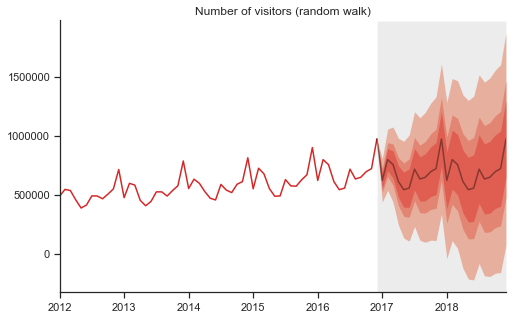

In [63]:

fig, ax = fanchart(y['2012-01':], pred_rw, intv1_rw, intv2_rw, intv3_rw)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Number of visitors (random walk)')

sns.despine()
plt.show()

# drift method

$\hat y_{t+h}=y_t + h \times \sum^t_{i=2} \frac{y_i - y_{i-1}}{t-1}$

$\sum^t_{i=2} \frac{y_i - y_{i-1}}{t-1}$ is the average change over time

In [15]:
h = 24
test=pd.period_range(start=y.index[-1]+1, periods=h)
t = len(y)
predict_drift = []


for h in range(1,len(test)+1):
    sum = 0
    for i in range(2,t+1):
        sum += (y.iloc[i-1]-y.iloc[i-2])/(t-1)
    yth = y.iloc[-1]+h*sum
    predict_drift.append(yth)

pred_drift=pd.Series(predict_drift, index=test) # the forecast repeats the last observed values h times
pred_drift

2017-01    9.743543e+05
2017-02    9.769087e+05
2017-03    9.794630e+05
2017-04    9.820174e+05
2017-05    9.845717e+05
2017-06    9.871260e+05
2017-07    9.896804e+05
2017-08    9.922347e+05
2017-09    9.947891e+05
2017-10    9.973434e+05
2017-11    9.998977e+05
2017-12    1.002452e+06
2018-01    1.005006e+06
2018-02    1.007561e+06
2018-03    1.010115e+06
2018-04    1.012669e+06
2018-05    1.015224e+06
2018-06    1.017778e+06
2018-07    1.020332e+06
2018-08    1.022887e+06
2018-09    1.025441e+06
2018-10    1.027995e+06
2018-11    1.030550e+06
2018-12    1.033104e+06
Freq: M, dtype: float64

In [18]:
intv1_drift = pd.concat([pred_drift-stats.norm.ppf(0.8)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred_drift+stats.norm.ppf(0.8)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv2_drift = pd.concat([pred_drift-stats.norm.ppf(0.9)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred_drift+stats.norm.ppf(0.9)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv3_drift = pd.concat([pred_drift-stats.norm.ppf(0.99)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred_drift+stats.norm.ppf(0.99)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)

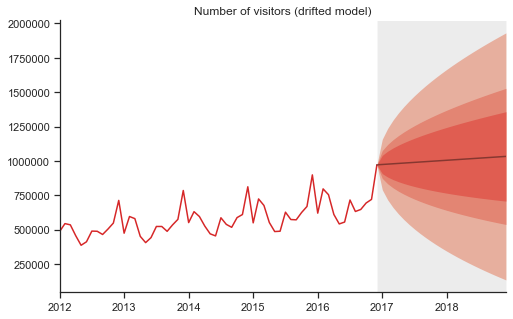

In [19]:
fig, ax = forecast.fanchart(y['01-2012':], pred_drift, intv1_drift, intv2_drift, intv3_drift)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Number of visitors (drifted model)')

sns.despine()
plt.show()

# exponential smoothing

In [20]:
# import forecast # you need to download the forecast.py file from the Canvas

ses_model=ses(y)
ses_model.fit()
fitted_ses=pd.Series(ses_model.smooth(), index=y.index)
ses_model.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.177 (0.056) 

 In-sample fit:
 MSE               4842866274.004
 Log-likelihood   -3921.629
 AIC               7849.259
 BIC               7860.488


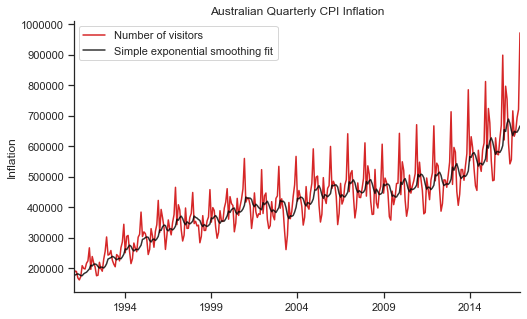

In [22]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red, label='Number of visitors')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

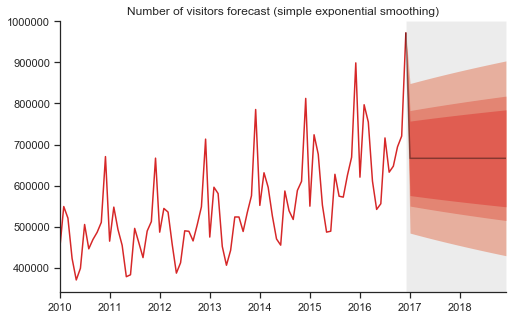

In [24]:
h=24

model = ses_model

test=pd.period_range(start=y.index[-1]+1, periods=h)

pred_ses=pd.Series(model.forecast(h), index=test)
# pred_ses 
intv1_ses=pd.DataFrame(ses_model.intervalforecast(h, level=.8), index=test)
intv2_ses=pd.DataFrame(ses_model.intervalforecast(h, level=.9), index=test)
intv3_ses=pd.DataFrame(ses_model.intervalforecast(h, level=.99), index=test)

fig, ax = fanchart(y['2010-01':], pred_ses, intv1_ses, intv2_ses, intv3_ses)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Number of visitors forecast (simple exponential smoothing)')

sns.despine()
plt.show()

# Holt-winters exponential smoothing

The Holt-Winters ES modifies the Holt ES technique so that it can be used in the presence of both trend and seasonality.

Build and train the model on the training data. In the above chart, the level of the time series seems to be increasing linearly. So we set the trend as additive. However, the seasonal variation around each level seems to be increasing in proportion to the current level. So we set the seasonality to multiplicative.

In [92]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

model = HWES(y, seasonal_periods=12, trend='add', seasonal='mul')
hwe_model = model.fit()
# fitted_ses=pd.Series(ses_model.smooth(), index=y.index)
print(hwe_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                   112295461018.712
Optimized:                         True   AIC                           6178.836
Trend:                         Additive   BIC                           6238.724
Seasonal:                Multiplicative   AICC                          6181.170
Seasonal Periods:                    12   Date:                 Tue, 03 Nov 2020
Box-Cox:                          False   Time:                         14:48:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4161687                alpha                 True
smoothing_slope          

# predictions

In [101]:
pred_hwe = hwe_model.forecast(steps=24)

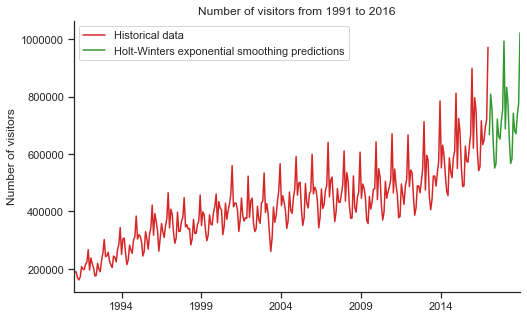

In [102]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red, label='Historical data')
# y_test.plot(color='orange',label='Acutual data')

pred_hwe.plot(color='orange', label='Holt-Winters exponential smoothing predictions', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Number of visitors')
ax.set_title('Number of visitors from 1991 to 2016')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

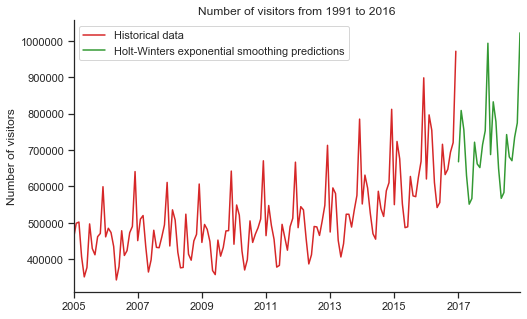

In [104]:
fig, ax= plt.subplots(figsize=(8,5))
y['2005-01':].plot(color=red, label='Historical data')
pred_hwe.plot(color='green', label='Holt-Winters exponential smoothing predictions', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Number of visitors')
ax.set_title('Number of visitors from 1991 to 2016')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

# Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are:

- Residual plot.
- Residula ACF.
- Residual distribution plots.

In [90]:
resid_ses=y-pred_hwe

Residual plot. The presence of patterns in the time series of
residuals (such as non-constant variance over time) may suggest
assumption violations and the need for alternative models.

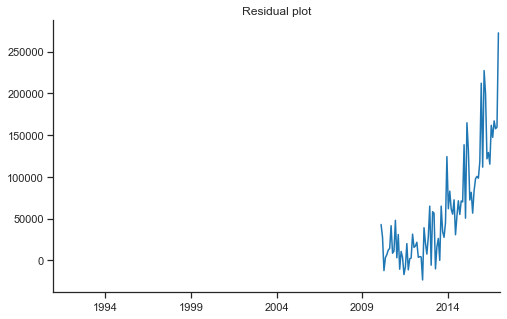

In [91]:
fig, ax= plt.subplots(figsize=(8,5))
resid_ses.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

Residual ACF plot. Well specified models should lead to small
and insignificant sample autocorrelations, consistent with a white
noise process.


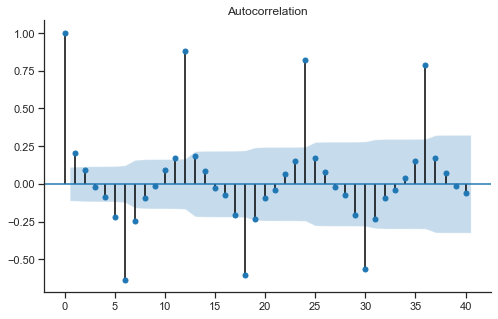

In [31]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid_ses, lags=40, ax=ax)
sns.despine()
plt.show()


Residual distribution plots (histogram, KDE, Q-Q plots, etc).
Inspecting the distribution of the residuals will suggest the
appropriate assumptions for interval forecasting.

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1a1d7510>)

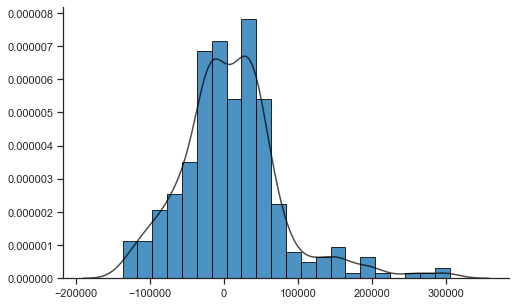

In [32]:
histogram(resid_ses)

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23533710>)

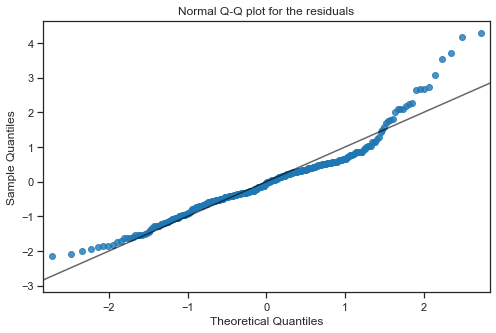

In [34]:
qq_plot(resid_ses)

# Model validation

In [118]:
validation=y['2010-01':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2010-01') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []

no_pred = len(y)-start
model = HWES(y[:'2010-01'], seasonal_periods=12, trend='add', seasonal='mul')
hwe = model.fit()
hwe_val = hwe.forecast(steps=no_pred)

# for i in range(no_pred):
    
#     pred2.append(hwe_model.forecast(steps=1)) 

# columns=[ 'SES', 'Actual']
# results = np.vstack([pred2,actual]).T
# results = pd.DataFrame(results, columns=columns, index=validation)
pred2

2010-02    506080.541646
2010-03    493291.628054
2010-04    434923.293190
2010-05    367128.670971
2010-06    391872.932460
               ...      
2016-09    480095.967100
2016-10    536587.618843
2016-11    560917.750500
2016-12    699199.987493
2017-01    518279.432320
Freq: M, Length: 84, dtype: float64